# 의도 탐지 예제

In [9]:
from transformers import pipeline

bert_ckpt = 'transformersbook/bert-base-uncased-finetuned-clinc'
pipe = pipeline("text-classification", model=bert_ckpt)

In [10]:
query = """Hey, I'd like to rent a vehicle from Nov 1st to Nov 15th in
Paris and I need a 15 passenger van"""
pipe(query)

[{'label': 'car_rental', 'score': 0.5490036010742188}]

## 벤치마크 클래스 만들기

In [11]:
class PerformanceBenchmark:
    def __init__(self, pipeline, dataset, optim_type="BERT baseline"):
        self.pipeline = pipeline
        self.dataset = dataset
        self.optim_type = optim_type

    def compute_accuracy(self):
        # 나중에 정의합니다
        pass

    def compute_size(self):
        # 나중에 정의합니다
        pass

    def time_pipeline(self):
        # 나중에 정의합니다
        pass

    def run_benchmark(self):
        metrics = {}
        metrics[self.optim_type] = self.compute_size()
        metrics[self.optim_type].update(self.time_pipeline())
        metrics[self.optim_type].update(self.compute_accuracy())
        return metrics

In [12]:
from datasets import load_dataset

clinc = load_dataset('clinc_oos', 'plus')

In [13]:
sample = clinc['test'][42]
sample

{'text': 'transfer $100 from my checking to saving account', 'intent': 133}

In [14]:
intents = clinc['test'].features['intent']
intents.int2str(sample['intent'])

'transfer'

In [15]:
# from datasets import load_metric

# accuracy_score = load_metric('accuracy')

In [16]:
# !pip install evaluate

In [17]:
import evaluate

accuracy_score = evaluate.load("accuracy")

In [18]:
def compute_accuracy(self):
    """PerformanceBenchmark.compute_accuracy() 메서드를 오버라이드합니다"""
    preds, labels = [], []
    for example in self.dataset:
        pred = self.pipeline(example["text"])[0]["label"]
        label = example["intent"]
        preds.append(intents.str2int(pred))
        labels.append(label)
    accuracy = accuracy_score.compute(predictions=preds, references=labels)
    print(f"테스트 세트 정확도 - {accuracy['accuracy']:.3f}")
    return accuracy

PerformanceBenchmark.compute_accuracy = compute_accuracy

In [19]:
list(pipe.model.state_dict().items())[42]

('bert.encoder.layer.2.attention.self.value.weight',
 tensor([[-1.0526e-02, -3.2215e-02,  2.2097e-02,  ..., -6.0953e-03,
           4.6521e-03,  2.9844e-02],
         [-1.4964e-02, -1.0915e-02,  5.2396e-04,  ...,  3.2047e-05,
          -2.6890e-02, -2.1943e-02],
         [-2.9640e-02, -3.7842e-03, -1.2582e-02,  ..., -1.0917e-02,
           3.1152e-02, -9.7786e-03],
         ...,
         [-1.5116e-02, -3.3226e-02,  4.2063e-02,  ..., -5.2652e-03,
           1.1093e-02,  2.9703e-03],
         [-3.6809e-02,  5.6848e-02, -2.6544e-02,  ..., -4.0114e-02,
           6.7487e-03,  1.0511e-03],
         [-2.4961e-02,  1.4747e-03, -5.4271e-02,  ...,  2.0004e-02,
           2.3981e-02, -4.2880e-02]]))

In [20]:
import torch
torch.save(pipe.model.state_dict(), 'model.pt')

In [21]:
import torch
from pathlib import Path

def compute_size(self):
    state_dict = self.pipeline.model.state_dict()
    tmp_path = Path("model.pt")
    torch.save(state_dict, tmp_path)
    size_mb = Path(tmp_path).stat().st_size /(1024*1024)
    tmp_path.unlink()
    print(f"모델 크기 (MB) - {size_mb:.2f}")
    return {"size_mb": size_mb}

PerformanceBenchmark.compute_size = compute_size    

In [22]:
from time import perf_counter

for _ in range(3):
    start_time = perf_counter()
    _ = pipe(query)
    latency = perf_counter() - start_time
    print(f'레이턴시 (ms) - {1000* latency :.3f}')

레이턴시 (ms) - 16.010
레이턴시 (ms) - 15.065
레이턴시 (ms) - 14.991


In [23]:
import numpy as np

def time_pipeline(self, query="What is the pin number for my account?"):
    latencies=[]
    for _ in range(10):
        _ = self.pipeline(query)
    for _ in range(100):
        start_time = perf_counter()
        _ = self.pipeline(query)
        latency = perf_counter() - start_time
        latencies.append(latency)
    time_avg_ms = 1000 * np.mean(latencies)
    time_std_ms = 1000 * np.std(latencies)
    print(f"평균 레이턴시 (ms) - {time_avg_ms:.2f} +\- {time_std_ms:.2f}")
    return {"time_avg_ms": time_avg_ms, "time_std_ms": time_std_ms}

PerformanceBenchmark.time_pipeline = time_pipeline    

In [24]:
pb = PerformanceBenchmark(pipe, clinc['test'])
perf_metrics = pb.run_benchmark()

모델 크기 (MB) - 418.15
평균 레이턴시 (ms) - 14.12 +\- 0.08
테스트 세트 정확도 - 0.867


# 지식 정제로 모델 크기 줄이기

## 지식 정제 트레이너 만들기

In [25]:
from transformers import TrainingArguments

class DistillationTrainingArguments(TrainingArguments):
    def __init__(self, *args, alpha=0.5, temperature=2.0, **kwargs):
        super().__init__(*args, **kwargs)
        self.alpha = alpha
        self.temperature = temperature

In [26]:
import torch.nn as nn
import torch.nn.functional as F
from transformers import Trainer

class DistillationTrainer(Trainer):
    def __init__(self, *args, teacher_model=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.teacher_model = teacher_model

    def compute_loss(self, model, inputs, return_outputs=False):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        inputs = inputs.to(device)
        outputs_stu = model(**inputs)
        # 스튜던트의 크로스 엔트로피 손실과 로짓을 추출합니다
        loss_ce = outputs_stu.loss
        logits_stu = outputs_stu.logits
        # 티처의 로짓을 추출합니다
        with torch.no_grad():
            outputs_tea = self.teacher_model(**inputs)
            logits_tea = outputs_tea.logits
        # 확률을 부드럽게하고 정제 손실을 계산합니다
        loss_fct = nn.KLDivLoss(reduction="batchmean")
        loss_kd = self.args.temperature ** 2 * loss_fct(
            F.log_softmax(logits_stu / self.args.temperature, dim=-1),
            F.softmax(logits_tea / self.args.temperature, dim=-1))
        # 가중 평균된 스튜던트 손실을 반환합니다
        loss = self.args.alpha * loss_ce + (1. - self.args.alpha) * loss_kd
        return (loss, outputs_stu) if return_outputs else loss

## 좋은 스튜던트 선택하기

In [27]:
clinc

DatasetDict({
    train: Dataset({
        features: ['text', 'intent'],
        num_rows: 15250
    })
    validation: Dataset({
        features: ['text', 'intent'],
        num_rows: 3100
    })
    test: Dataset({
        features: ['text', 'intent'],
        num_rows: 5500
    })
})

In [28]:
from transformers import AutoTokenizer

student_ckpt = 'distilbert-base-uncased'
student_tokenizer = AutoTokenizer.from_pretrained(student_ckpt)

def tokenizer_text(batch):
    return student_tokenizer(batch['text'], truncation=True)

clinc_enc = clinc.map(tokenizer_text, batched=True, remove_columns=['text'])
clinc_enc = clinc_enc.rename_column('intent', 'labels')

Map:   0%|          | 0/3100 [00:00<?, ? examples/s]

In [29]:
clinc_enc

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 15250
    })
    validation: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 3100
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 5500
    })
})

In [46]:
from huggingface_hub import notebook_login

notebook_login()

In [47]:
def compute_metrics(pred):
    predictions, labels = pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy_score.compute(predictions=predictions, references=labels)

In [48]:
batch_size = 48
finetuned_ckpt = 'distilbert-base-uncased-fintuned-clinc'
student_training_args = DistillationTrainingArguments(
    output_dir=finetuned_ckpt, evaluation_strategy='epoch',
    num_train_epochs=5, learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    alpha=1, weight_decay=0.01, push_to_hub=True)

In [49]:
student_training_args.logging_steps = len(clinc_enc['train']) // batch_size
student_training_args.disable_tqdm = False
student_training_args.save_steps = 1e9
# 트랜스포머 4.23.0 버전부터 로깅 수준을 문자열로 지정해야 합니다.
# student_training_args.log_level = 40
student_training_args.log_level = 'error'

In [50]:
%env TOKENIZERS_PARALLELISM=false

env: TOKENIZERS_PARALLELISM=false


In [51]:
id2label = pipe.model.config.id2label
label2id = pipe.model.config.label2id

In [52]:
from transformers import AutoConfig

num_labels = intents.num_classes
student_config = (AutoConfig
                  .from_pretrained(student_ckpt, num_labels=num_labels,
                                   id2label=id2label, label2id=label2id))

In [53]:
import torch
from transformers import AutoModelForSequenceClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def student_init():
    return (AutoModelForSequenceClassification
            .from_pretrained(student_ckpt, config=student_config).to(device))

In [56]:
teacher_ckpt = "transformersbook/bert-base-uncased-finetuned-clinc"
teacher_model = (AutoModelForSequenceClassification
                 .from_pretrained(teacher_ckpt, num_labels=num_labels)
                 .to(device))

In [57]:
distilbert_trainer = DistillationTrainer(model_init=student_init,
    teacher_model=teacher_model, args=student_training_args,
    train_dataset=clinc_enc['train'], eval_dataset=clinc_enc['validation'],
    compute_metrics=compute_metrics, tokenizer=student_tokenizer)

distilbert_trainer.train()

/home/restful3/anaconda3/envs/trading/lib/python3.9/site-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'Repository' (from 'huggingface_hub.repository') is deprecated and will be removed from version '1.0'. Please prefer the http-based alternatives instead. Given its large adoption in legacy code, the complete removal is only planned on next major release.
For more details, please read https://huggingface.co/docs/huggingface_hub/concepts/git_vs_http.
  warnings.warn(warning_message, FutureWarning)
Cloning https://huggingface.co/restful3/distilbert-base-uncased-fintuned-clinc into local empty directory.
/home/restful3/anaconda3/envs/trading/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,4.286400,3.281807,0.742581
2,2.624800,1.874040,0.834516
3,1.543100,1.159181,0.892258
4,1.011500,0.859684,0.910645
5,0.799800,0.776815,0.915161


TrainOutput(global_step=1590, training_loss=2.0491743006796206, metrics={'train_runtime': 174.3292, 'train_samples_per_second': 437.391, 'train_steps_per_second': 9.121, 'total_flos': 413896353421488.0, 'train_loss': 2.0491743006796206, 'epoch': 5.0})

In [58]:
distilbert_trainer.push_to_hub("Training completed!")

Upload file pytorch_model.bin:   0%|          | 1.00/256M [00:00<?, ?B/s]

Upload file training_args.bin:   0%|          | 1.00/4.30k [00:00<?, ?B/s]

To https://huggingface.co/restful3/distilbert-base-uncased-fintuned-clinc
   7d1f08f..cf11101  main -> main

To https://huggingface.co/restful3/distilbert-base-uncased-fintuned-clinc
   cf11101..4505d2b  main -> main



'https://huggingface.co/restful3/distilbert-base-uncased-fintuned-clinc/commit/cf1110135cfd462fdb11aef6e32326d666b504f4'

In [59]:
# `haesun`를 자신의 허브 사용자 이름으로 바꾸세요.
finetuned_ckpt = "restful3/distilbert-base-uncased-finetuned-clinc"
pipe = pipeline("text-classification", model=finetuned_ckpt)

In [60]:
optim_type = "DistilBERT"
pb = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

모델 크기 (MB) - 255.88
평균 레이턴시 (ms) - 6.51 +\- 0.20
테스트 세트 정확도 - 0.862


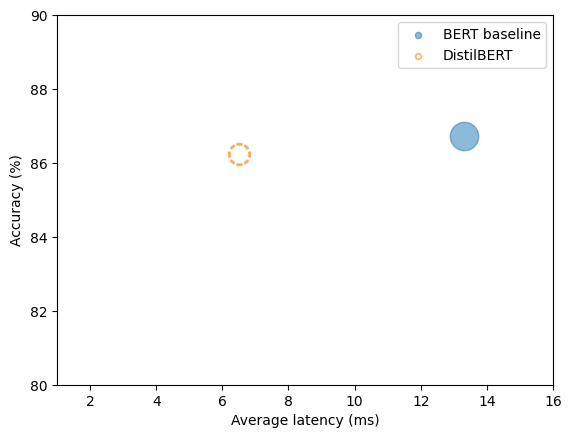

In [62]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_metrics(perf_metrics, current_optim_type):
    df = pd.DataFrame.from_dict(perf_metrics, orient='index')

    for idx in df.index:
        df_opt = df.loc[idx]
        # 현재 최적화 방법을 점선으로 그립니다
        if idx == current_optim_type:
            plt.scatter(df_opt["time_avg_ms"], df_opt["accuracy"] * 100,
                        alpha=0.5, s=df_opt["size_mb"], label=idx,
                        marker='$\u25CC$')
        else:
            plt.scatter(df_opt["time_avg_ms"], df_opt["accuracy"] * 100,
                        s=df_opt["size_mb"], label=idx, alpha=0.5)

    legend = plt.legend(bbox_to_anchor=(1,1))
    for handle in legend.legend_handles:
        handle.set_sizes([20])

    plt.ylim(80,90)
    # 가장 느린 모델을 사용해 x 축 범위를 정합니다
    xlim = int(perf_metrics["BERT baseline"]["time_avg_ms"] + 3)
    plt.xlim(1, xlim)
    plt.ylabel("Accuracy (%)")
    plt.xlabel("Average latency (ms)")
    plt.show()

plot_metrics(perf_metrics, optim_type)

## 옵투나로 좋은 하이퍼파라미터 찾기

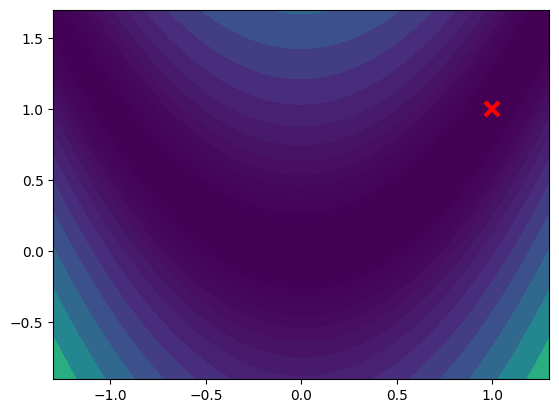

In [63]:
# 두 변수를 가진 로젠브록 함수 그래프
import matplotlib.pyplot as plt
import numpy as np

def f(x, y):
    return (1-x)**2+100*(y-x**2)**2

X, Y = np.meshgrid(np.linspace(-2, 2, 250), np.linspace(-1, 3, 250))
Z = f(X,Y)
_, ax = plt.subplots()
ax.plot([1], [1], 'x', mew=3, markersize=10, color="red")
ax.contourf(X, Y, Z, np.logspace(-1, 3, 30), cmap='viridis', extend="both")
ax.set_xlim(-1.3, 1.3)
ax.set_ylim(-0.9, 1.7)
plt.show()

In [64]:
def objective(trial):
    x = trial.suggest_float("x", -2, 2)
    y = trial.suggest_float("y", -2, 2)
    return (1 - x) ** 2 + 100 * (y - x ** 2) ** 2

In [66]:
import optuna

study = optuna.create_study()
study.optimize(objective, n_trials=1000)

[I 2024-03-25 20:25:02,912] A new study created in memory with name: no-name-9e519141-66b3-4029-bf30-a0db24b43204
[I 2024-03-25 20:25:02,913] Trial 0 finished with value: 414.21881463216766 and parameters: {'x': 1.2739280519350618, 'y': -0.4121595980536643}. Best is trial 0 with value: 414.21881463216766.
[I 2024-03-25 20:25:02,914] Trial 1 finished with value: 510.7382412871902 and parameters: {'x': -0.8707742377391949, 'y': -1.4939477002858532}. Best is trial 0 with value: 414.21881463216766.
[I 2024-03-25 20:25:02,914] Trial 2 finished with value: 69.2887434017097 and parameters: {'x': 1.1340839416766024, 'y': 0.4538557830833789}. Best is trial 2 with value: 69.2887434017097.
[I 2024-03-25 20:25:02,914] Trial 3 finished with value: 351.9369882309562 and parameters: {'x': 0.0300166124119432, 'y': 1.8743900427819908}. Best is trial 2 with value: 69.2887434017097.
[I 2024-03-25 20:25:02,915] Trial 4 finished with value: 1857.0053800395115 and parameters: {'x': -1.8283409847693148, 'y':

[I 2024-03-25 20:25:03,019] Trial 42 finished with value: 10.678810801467991 and parameters: {'x': 0.03978311608567486, 'y': 0.3139413737672032}. Best is trial 31 with value: 0.11278639834960667.
[I 2024-03-25 20:25:03,023] Trial 43 finished with value: 97.81244341641487 and parameters: {'x': 1.1324705217079332, 'y': 0.29357646827737055}. Best is trial 31 with value: 0.11278639834960667.
[I 2024-03-25 20:25:03,026] Trial 44 finished with value: 23.515907845814247 and parameters: {'x': 0.7891019292603237, 'y': 1.1071550722839585}. Best is trial 31 with value: 0.11278639834960667.
[I 2024-03-25 20:25:03,029] Trial 45 finished with value: 35.6017420211413 and parameters: {'x': 0.43728518352325896, 'y': -0.4027942443707184}. Best is trial 31 with value: 0.11278639834960667.
[I 2024-03-25 20:25:03,032] Trial 46 finished with value: 185.48626017798617 and parameters: {'x': 0.13221724796454637, 'y': 1.3766473701908393}. Best is trial 31 with value: 0.11278639834960667.
[I 2024-03-25 20:25:03,

[I 2024-03-25 20:25:03,163] Trial 85 finished with value: 6.557873161057978 and parameters: {'x': 0.5134153145851844, 'y': 0.515013433063719}. Best is trial 31 with value: 0.11278639834960667.
[I 2024-03-25 20:25:03,166] Trial 86 finished with value: 12.351751939590676 and parameters: {'x': 1.1830324831722958, 'y': 1.0485921955525104}. Best is trial 31 with value: 0.11278639834960667.
[I 2024-03-25 20:25:03,170] Trial 87 finished with value: 26.46198066848133 and parameters: {'x': 0.6275309681360655, 'y': 0.9068569786021965}. Best is trial 31 with value: 0.11278639834960667.
[I 2024-03-25 20:25:03,173] Trial 88 finished with value: 8.538283003350537 and parameters: {'x': 0.7490439836492182, 'y': 0.2699431342920492}. Best is trial 31 with value: 0.11278639834960667.
[I 2024-03-25 20:25:03,177] Trial 89 finished with value: 309.88110546039036 and parameters: {'x': 1.065640963180623, 'y': -0.6247411151957503}. Best is trial 31 with value: 0.11278639834960667.
[I 2024-03-25 20:25:03,180] T

[I 2024-03-25 20:25:03,311] Trial 127 finished with value: 0.48406301504812316 and parameters: {'x': 0.6671671229054794, 'y': 0.3840148921348169}. Best is trial 111 with value: 0.024502050771495983.
[I 2024-03-25 20:25:03,315] Trial 128 finished with value: 1.5227583446248063 and parameters: {'x': 0.36959044061843666, 'y': 0.2426792380086995}. Best is trial 111 with value: 0.024502050771495983.
[I 2024-03-25 20:25:03,318] Trial 129 finished with value: 28.64016394895721 and parameters: {'x': 1.223730803500886, 'y': 0.9628198896507606}. Best is trial 111 with value: 0.024502050771495983.
[I 2024-03-25 20:25:03,322] Trial 130 finished with value: 27.960605695562354 and parameters: {'x': 1.0995223059736188, 'y': 0.6802650760517976}. Best is trial 111 with value: 0.024502050771495983.
[I 2024-03-25 20:25:03,326] Trial 131 finished with value: 26.663033985027425 and parameters: {'x': 0.7833743906297754, 'y': 0.09776742732722671}. Best is trial 111 with value: 0.024502050771495983.
[I 2024-0

[I 2024-03-25 20:25:03,463] Trial 169 finished with value: 0.11894963189672803 and parameters: {'x': 0.6579629257810796, 'y': 0.42848771607113156}. Best is trial 111 with value: 0.024502050771495983.
[I 2024-03-25 20:25:03,467] Trial 170 finished with value: 0.6961924501306884 and parameters: {'x': 0.7035964314069774, 'y': 0.4170519528370725}. Best is trial 111 with value: 0.024502050771495983.
[I 2024-03-25 20:25:03,471] Trial 171 finished with value: 1.077035213891679 and parameters: {'x': 0.6033477314896762, 'y': 0.45992958997670075}. Best is trial 111 with value: 0.024502050771495983.
[I 2024-03-25 20:25:03,474] Trial 172 finished with value: 91.89641244575841 and parameters: {'x': -1.1529615435902345, 'y': 0.39518345181027537}. Best is trial 111 with value: 0.024502050771495983.
[I 2024-03-25 20:25:03,478] Trial 173 finished with value: 0.7378468669293831 and parameters: {'x': 0.6475883765346879, 'y': 0.34103470382867895}. Best is trial 111 with value: 0.024502050771495983.
[I 202

[I 2024-03-25 20:25:03,621] Trial 211 finished with value: 0.2559383409071532 and parameters: {'x': 0.5496602139966473, 'y': 0.32517682113879903}. Best is trial 111 with value: 0.024502050771495983.
[I 2024-03-25 20:25:03,625] Trial 212 finished with value: 0.1384382361813206 and parameters: {'x': 0.681484788275014, 'y': 0.4836533382179206}. Best is trial 111 with value: 0.024502050771495983.
[I 2024-03-25 20:25:03,628] Trial 213 finished with value: 0.7268981275972265 and parameters: {'x': 0.7573121741717911, 'y': 0.49179041649618704}. Best is trial 111 with value: 0.024502050771495983.
[I 2024-03-25 20:25:03,632] Trial 214 finished with value: 2.6628815272061686 and parameters: {'x': 0.9061445240396379, 'y': 0.6581846492363324}. Best is trial 111 with value: 0.024502050771495983.
[I 2024-03-25 20:25:03,636] Trial 215 finished with value: 1.6186972932079216 and parameters: {'x': 0.678097383742182, 'y': 0.5829044852926083}. Best is trial 111 with value: 0.024502050771495983.
[I 2024-03

[I 2024-03-25 20:25:03,784] Trial 253 finished with value: 1.7809373410022993 and parameters: {'x': 0.7597690856417953, 'y': 0.7085207835584103}. Best is trial 243 with value: 0.021902885952094414.
[I 2024-03-25 20:25:03,788] Trial 254 finished with value: 2.317275364250271 and parameters: {'x': 0.6763303182777028, 'y': 0.6061678943485158}. Best is trial 243 with value: 0.021902885952094414.
[I 2024-03-25 20:25:03,792] Trial 255 finished with value: 1.6398320074791897 and parameters: {'x': 0.8055649119632358, 'y': 0.5223636219713866}. Best is trial 243 with value: 0.021902885952094414.
[I 2024-03-25 20:25:03,796] Trial 256 finished with value: 8.954612515028348 and parameters: {'x': 0.9822802107207576, 'y': 0.665637073057543}. Best is trial 243 with value: 0.021902885952094414.
[I 2024-03-25 20:25:03,800] Trial 257 finished with value: 0.019209393603912096 and parameters: {'x': 0.8694762868284429, 'y': 0.7606505087220085}. Best is trial 257 with value: 0.019209393603912096.
[I 2024-03-

[I 2024-03-25 20:25:03,954] Trial 295 finished with value: 2.4619919985163783 and parameters: {'x': 1.0438568399765829, 'y': 0.9327910448412133}. Best is trial 257 with value: 0.019209393603912096.
[I 2024-03-25 20:25:03,958] Trial 296 finished with value: 5.041746342436579 and parameters: {'x': 0.6215282387309353, 'y': 0.6076230271485367}. Best is trial 257 with value: 0.019209393603912096.
[I 2024-03-25 20:25:03,963] Trial 297 finished with value: 1.0666431481639658 and parameters: {'x': 0.9009815027778925, 'y': 0.7089650183153426}. Best is trial 257 with value: 0.019209393603912096.
[I 2024-03-25 20:25:03,967] Trial 298 finished with value: 1.7518106573912324 and parameters: {'x': 0.7200892905323598, 'y': 0.6478908935280276}. Best is trial 257 with value: 0.019209393603912096.
[I 2024-03-25 20:25:03,971] Trial 299 finished with value: 3.274704202725239 and parameters: {'x': 0.8207755082714516, 'y': 0.8537441646942228}. Best is trial 257 with value: 0.019209393603912096.
[I 2024-03-2

[I 2024-03-25 20:25:04,129] Trial 337 finished with value: 3.060532019735066 and parameters: {'x': 0.7198930233857396, 'y': 0.6909327365116867}. Best is trial 257 with value: 0.019209393603912096.
[I 2024-03-25 20:25:04,133] Trial 338 finished with value: 1.1101728384561613 and parameters: {'x': 0.7727147440760372, 'y': 0.4942039539591494}. Best is trial 257 with value: 0.019209393603912096.
[I 2024-03-25 20:25:04,137] Trial 339 finished with value: 0.15716730466684667 and parameters: {'x': 0.6038747814710171, 'y': 0.36307693586285095}. Best is trial 257 with value: 0.019209393603912096.
[I 2024-03-25 20:25:04,141] Trial 340 finished with value: 1.3760433435990354 and parameters: {'x': 0.8842649826059557, 'y': 0.6651920126157199}. Best is trial 257 with value: 0.019209393603912096.
[I 2024-03-25 20:25:04,145] Trial 341 finished with value: 12.840051549904036 and parameters: {'x': 0.47193007540548104, 'y': 0.5771357397680315}. Best is trial 257 with value: 0.019209393603912096.
[I 2024-

[I 2024-03-25 20:25:04,304] Trial 379 finished with value: 0.19906675713502278 and parameters: {'x': 0.5707382518661466, 'y': 0.313576171408368}. Best is trial 257 with value: 0.019209393603912096.
[I 2024-03-25 20:25:04,308] Trial 380 finished with value: 23.310061198695823 and parameters: {'x': 1.0660993585210254, 'y': 0.653808149705494}. Best is trial 257 with value: 0.019209393603912096.
[I 2024-03-25 20:25:04,313] Trial 381 finished with value: 7.092046099611792 and parameters: {'x': 0.8262360816662275, 'y': 0.41692460558227085}. Best is trial 257 with value: 0.019209393603912096.
[I 2024-03-25 20:25:04,317] Trial 382 finished with value: 0.36837576467320104 and parameters: {'x': 0.7679186259515669, 'y': 0.533617468271875}. Best is trial 257 with value: 0.019209393603912096.
[I 2024-03-25 20:25:04,321] Trial 383 finished with value: 0.3654124411064012 and parameters: {'x': 0.891012978479391, 'y': 0.734445379913427}. Best is trial 257 with value: 0.019209393603912096.
[I 2024-03-25

[I 2024-03-25 20:25:04,485] Trial 421 finished with value: 0.765750660447225 and parameters: {'x': 0.8946287638527127, 'y': 0.8872310782621369}. Best is trial 257 with value: 0.019209393603912096.
[I 2024-03-25 20:25:04,490] Trial 422 finished with value: 4.389531832064468 and parameters: {'x': 0.8016269388277293, 'y': 0.4340348987260496}. Best is trial 257 with value: 0.019209393603912096.
[I 2024-03-25 20:25:04,494] Trial 423 finished with value: 12.497078264466879 and parameters: {'x': 0.9793629391247715, 'y': 0.605645721657967}. Best is trial 257 with value: 0.019209393603912096.
[I 2024-03-25 20:25:04,499] Trial 424 finished with value: 208.0701248324107 and parameters: {'x': 1.466429282093481, 'y': 0.7087055463639984}. Best is trial 257 with value: 0.019209393603912096.
[I 2024-03-25 20:25:04,503] Trial 425 finished with value: 114.68683669340795 and parameters: {'x': 0.6611798684297832, 'y': 1.507542103095032}. Best is trial 257 with value: 0.019209393603912096.
[I 2024-03-25 20

[I 2024-03-25 20:25:04,672] Trial 463 finished with value: 3.133534883012719 and parameters: {'x': 1.01105102441109, 'y': 0.8452096898696837}. Best is trial 438 with value: 0.014094934119156216.
[I 2024-03-25 20:25:04,677] Trial 464 finished with value: 133.42349831184305 and parameters: {'x': -0.7868438616786069, 'y': -0.5220633448916625}. Best is trial 438 with value: 0.014094934119156216.
[I 2024-03-25 20:25:04,681] Trial 465 finished with value: 3.282400489712661 and parameters: {'x': 0.9049518205494881, 'y': 0.9998622661013673}. Best is trial 438 with value: 0.014094934119156216.
[I 2024-03-25 20:25:04,686] Trial 466 finished with value: 259.6572321634434 and parameters: {'x': 1.2118908065414384, 'y': -0.14256967441505675}. Best is trial 438 with value: 0.014094934119156216.
[I 2024-03-25 20:25:04,690] Trial 467 finished with value: 328.7325391628019 and parameters: {'x': 0.7771667075059834, 'y': -1.2089732555097559}. Best is trial 438 with value: 0.014094934119156216.
[I 2024-03-

[I 2024-03-25 20:25:04,864] Trial 505 finished with value: 24.322631958322617 and parameters: {'x': 0.9739243373405617, 'y': 0.45535570382655655}. Best is trial 438 with value: 0.014094934119156216.
[I 2024-03-25 20:25:04,869] Trial 506 finished with value: 0.1114685904980289 and parameters: {'x': 0.7882543230595447, 'y': 0.5955316333930751}. Best is trial 438 with value: 0.014094934119156216.
[I 2024-03-25 20:25:04,873] Trial 507 finished with value: 5.753253110388574 and parameters: {'x': 0.705340173690374, 'y': 0.7355473764941824}. Best is trial 438 with value: 0.014094934119156216.
[I 2024-03-25 20:25:04,878] Trial 508 finished with value: 4.551968853535084 and parameters: {'x': 0.8534959970245073, 'y': 0.5156055771284322}. Best is trial 438 with value: 0.014094934119156216.
[I 2024-03-25 20:25:04,883] Trial 509 finished with value: 0.4285225412759098 and parameters: {'x': 1.0163682648628742, 'y': 0.9675632837869554}. Best is trial 438 with value: 0.014094934119156216.
[I 2024-03-2

[I 2024-03-25 20:25:05,062] Trial 547 finished with value: 2.9775569056072397 and parameters: {'x': 1.0830681034565264, 'y': 1.0006805886053602}. Best is trial 517 with value: 0.01405462905275559.
[I 2024-03-25 20:25:05,067] Trial 548 finished with value: 6.163181465517617 and parameters: {'x': 1.1494000341352457, 'y': 1.0733128297225516}. Best is trial 517 with value: 0.01405462905275559.
[I 2024-03-25 20:25:05,072] Trial 549 finished with value: 0.0392919006042181 and parameters: {'x': 0.9717525620581913, 'y': 0.9246831583670196}. Best is trial 517 with value: 0.01405462905275559.
[I 2024-03-25 20:25:05,077] Trial 550 finished with value: 14.963748841877896 and parameters: {'x': 1.1762450710072643, 'y': 0.9971241229114771}. Best is trial 517 with value: 0.01405462905275559.
[I 2024-03-25 20:25:05,081] Trial 551 finished with value: 0.024985212239158387 and parameters: {'x': 1.0222774810611233, 'y': 1.0294023102770244}. Best is trial 517 with value: 0.01405462905275559.
[I 2024-03-25 

[I 2024-03-25 20:25:05,267] Trial 589 finished with value: 0.07128428711951132 and parameters: {'x': 0.9189018029644063, 'y': 0.8189428802126056}. Best is trial 576 with value: 0.01005307731172122.
[I 2024-03-25 20:25:05,272] Trial 590 finished with value: 0.21017246637538145 and parameters: {'x': 0.9779858395086702, 'y': 0.9106646171048485}. Best is trial 576 with value: 0.01005307731172122.
[I 2024-03-25 20:25:05,277] Trial 591 finished with value: 0.08546712773294539 and parameters: {'x': 0.9070148017540939, 'y': 0.850392430592084}. Best is trial 576 with value: 0.01005307731172122.
[I 2024-03-25 20:25:05,282] Trial 592 finished with value: 0.6947903674592278 and parameters: {'x': 1.032840936539404, 'y': 0.9834710347031682}. Best is trial 576 with value: 0.01005307731172122.
[I 2024-03-25 20:25:05,287] Trial 593 finished with value: 8.047562957003565 and parameters: {'x': -1.0116087866452053, 'y': 0.8233275125960547}. Best is trial 576 with value: 0.01005307731172122.
[I 2024-03-25 

[I 2024-03-25 20:25:05,478] Trial 631 finished with value: 60.83815413030744 and parameters: {'x': 0.9287900480835938, 'y': 1.6426066141656537}. Best is trial 576 with value: 0.01005307731172122.
[I 2024-03-25 20:25:05,483] Trial 632 finished with value: 3.2364939770512606 and parameters: {'x': 0.8288893263618573, 'y': 0.8661445085866738}. Best is trial 576 with value: 0.01005307731172122.
[I 2024-03-25 20:25:05,488] Trial 633 finished with value: 986.526852126632 and parameters: {'x': 1.9741964323295593, 'y': 0.7580602215912723}. Best is trial 576 with value: 0.01005307731172122.
[I 2024-03-25 20:25:05,493] Trial 634 finished with value: 3.5316425320748537 and parameters: {'x': 1.0082040374798729, 'y': 0.8285505231797585}. Best is trial 576 with value: 0.01005307731172122.
[I 2024-03-25 20:25:05,498] Trial 635 finished with value: 0.6772211228755385 and parameters: {'x': 0.9164767235774155, 'y': 0.9217980760613154}. Best is trial 576 with value: 0.01005307731172122.
[I 2024-03-25 20:2

[I 2024-03-25 20:25:05,694] Trial 673 finished with value: 4.240415572042034 and parameters: {'x': 0.9935569613904996, 'y': 1.1930771211095788}. Best is trial 667 with value: 0.005363402800728172.
[I 2024-03-25 20:25:05,699] Trial 674 finished with value: 1.3994183000271605 and parameters: {'x': 1.063661648629526, 'y': 1.0132505130515816}. Best is trial 667 with value: 0.005363402800728172.
[I 2024-03-25 20:25:05,704] Trial 675 finished with value: 4.205773405057525 and parameters: {'x': 1.133764992151017, 'y': 1.0807799453532152}. Best is trial 667 with value: 0.005363402800728172.
[I 2024-03-25 20:25:05,709] Trial 676 finished with value: 0.04167630008494849 and parameters: {'x': 0.9772101957560806, 'y': 0.9752269362574879}. Best is trial 667 with value: 0.005363402800728172.
[I 2024-03-25 20:25:05,715] Trial 677 finished with value: 1.0386595183470946 and parameters: {'x': 1.2204109037537945, 'y': 1.3899000829896269}. Best is trial 667 with value: 0.005363402800728172.
[I 2024-03-25

[I 2024-03-25 20:25:05,915] Trial 715 finished with value: 17.29223148697693 and parameters: {'x': 1.2634846140923601, 'y': 1.1813896671114652}. Best is trial 680 with value: 0.0016161742879118191.
[I 2024-03-25 20:25:05,920] Trial 716 finished with value: 0.7119781691521203 and parameters: {'x': 0.9927449963805447, 'y': 1.0699183076328826}. Best is trial 680 with value: 0.0016161742879118191.
[I 2024-03-25 20:25:05,926] Trial 717 finished with value: 1.7922020921242228 and parameters: {'x': 0.9129328359216625, 'y': 0.9670360856023706}. Best is trial 680 with value: 0.0016161742879118191.
[I 2024-03-25 20:25:05,931] Trial 718 finished with value: 76.07716708636464 and parameters: {'x': 0.15191571539178494, 'y': 0.8911677816646879}. Best is trial 680 with value: 0.0016161742879118191.
[I 2024-03-25 20:25:05,936] Trial 719 finished with value: 0.37030176995437114 and parameters: {'x': 1.0311190692500058, 'y': 1.1239793392080404}. Best is trial 680 with value: 0.0016161742879118191.
[I 20

[I 2024-03-25 20:25:06,143] Trial 757 finished with value: 299.32864150114904 and parameters: {'x': 1.235968903663305, 'y': -0.20233162043486852}. Best is trial 680 with value: 0.0016161742879118191.
[I 2024-03-25 20:25:06,148] Trial 758 finished with value: 21.346664757222907 and parameters: {'x': 0.8802712437721602, 'y': 1.2367468140759417}. Best is trial 680 with value: 0.0016161742879118191.
[I 2024-03-25 20:25:06,154] Trial 759 finished with value: 0.048488350799960854 and parameters: {'x': 1.0185230158552767, 'y': 1.0593311594133654}. Best is trial 680 with value: 0.0016161742879118191.
[I 2024-03-25 20:25:06,159] Trial 760 finished with value: 1000.8305668835231 and parameters: {'x': 1.626003683835949, 'y': -0.5190832281640143}. Best is trial 680 with value: 0.0016161742879118191.
[I 2024-03-25 20:25:06,165] Trial 761 finished with value: 0.210041576390412 and parameters: {'x': 0.921654940856864, 'y': 0.8042921406524479}. Best is trial 680 with value: 0.0016161742879118191.
[I 2

[I 2024-03-25 20:25:06,377] Trial 799 finished with value: 20.152499273282782 and parameters: {'x': 1.217228159658395, 'y': 1.0332549280262593}. Best is trial 787 with value: 0.0012027194599135117.
[I 2024-03-25 20:25:06,383] Trial 800 finished with value: 10.48824778938496 and parameters: {'x': 1.1221366713448295, 'y': 0.9355654564091231}. Best is trial 787 with value: 0.0012027194599135117.
[I 2024-03-25 20:25:06,388] Trial 801 finished with value: 0.03533116168520786 and parameters: {'x': 0.9869954442054792, 'y': 0.9929115516757463}. Best is trial 787 with value: 0.0012027194599135117.
[I 2024-03-25 20:25:06,394] Trial 802 finished with value: 0.08089080554777939 and parameters: {'x': 1.0644455291855177, 'y': 1.1607458331727067}. Best is trial 787 with value: 0.0012027194599135117.
[I 2024-03-25 20:25:06,399] Trial 803 finished with value: 48.19740132449185 and parameters: {'x': 0.9518876864168216, 'y': 1.6003169786862954}. Best is trial 787 with value: 0.0012027194599135117.
[I 202

[I 2024-03-25 20:25:06,617] Trial 841 finished with value: 4.777241033214384 and parameters: {'x': 0.8091733271129823, 'y': 0.87249585769099}. Best is trial 787 with value: 0.0012027194599135117.
[I 2024-03-25 20:25:06,622] Trial 842 finished with value: 200.83233487067002 and parameters: {'x': 1.0323634501890293, 'y': -0.3513752664913238}. Best is trial 787 with value: 0.0012027194599135117.
[I 2024-03-25 20:25:06,628] Trial 843 finished with value: 2.721521376515236 and parameters: {'x': 0.9050460913097661, 'y': 0.9838052741086666}. Best is trial 787 with value: 0.0012027194599135117.
[I 2024-03-25 20:25:06,634] Trial 844 finished with value: 49.35103685252358 and parameters: {'x': -0.6710519426457947, 'y': 1.1326494984363522}. Best is trial 787 with value: 0.0012027194599135117.
[I 2024-03-25 20:25:06,640] Trial 845 finished with value: 33.904684519278426 and parameters: {'x': 1.1533078027391057, 'y': 0.7480434525681015}. Best is trial 787 with value: 0.0012027194599135117.
[I 2024-

[I 2024-03-25 20:25:06,863] Trial 883 finished with value: 1.0772368122109437 and parameters: {'x': 0.9416162343878076, 'y': 0.7830154532208077}. Best is trial 787 with value: 0.0012027194599135117.
[I 2024-03-25 20:25:06,869] Trial 884 finished with value: 4.6207671961189 and parameters: {'x': 0.824261498497159, 'y': 0.8936471442865698}. Best is trial 787 with value: 0.0012027194599135117.
[I 2024-03-25 20:25:06,875] Trial 885 finished with value: 16.342428492906464 and parameters: {'x': 1.0558287768261039, 'y': 0.7105552619373038}. Best is trial 787 with value: 0.0012027194599135117.
[I 2024-03-25 20:25:06,881] Trial 886 finished with value: 2.7991260930144906 and parameters: {'x': 0.9676266463225756, 'y': 1.1035758931498572}. Best is trial 787 with value: 0.0012027194599135117.
[I 2024-03-25 20:25:06,887] Trial 887 finished with value: 0.4232673157400235 and parameters: {'x': 0.8841168422903632, 'y': 0.8456812138541028}. Best is trial 787 with value: 0.0012027194599135117.
[I 2024-0

[I 2024-03-25 20:25:07,116] Trial 925 finished with value: 10.258795575753657 and parameters: {'x': 0.7604580180753644, 'y': 0.8976929409848341}. Best is trial 787 with value: 0.0012027194599135117.
[I 2024-03-25 20:25:07,122] Trial 926 finished with value: 0.020557942576683468 and parameters: {'x': 1.0250959771405368, 'y': 1.0367050578801678}. Best is trial 787 with value: 0.0012027194599135117.
[I 2024-03-25 20:25:07,128] Trial 927 finished with value: 98.72239306491883 and parameters: {'x': -0.4357615191611638, 'y': 1.173051271787969}. Best is trial 787 with value: 0.0012027194599135117.
[I 2024-03-25 20:25:07,134] Trial 928 finished with value: 18.909377965623218 and parameters: {'x': 1.2479087876442991, 'y': 1.12313443922705}. Best is trial 787 with value: 0.0012027194599135117.
[I 2024-03-25 20:25:07,140] Trial 929 finished with value: 1.900151075235296 and parameters: {'x': 1.1857885195948412, 'y': 1.2695062108858124}. Best is trial 787 with value: 0.0012027194599135117.
[I 2024

[I 2024-03-25 20:25:07,371] Trial 967 finished with value: 0.2823129914019143 and parameters: {'x': 1.109345873577227, 'y': 1.282644081605668}. Best is trial 946 with value: 0.0008342570359147451.
[I 2024-03-25 20:25:07,377] Trial 968 finished with value: 0.16538291199531796 and parameters: {'x': 0.9874536245975765, 'y': 1.0157126004646073}. Best is trial 946 with value: 0.0008342570359147451.
[I 2024-03-25 20:25:07,383] Trial 969 finished with value: 1.0194777164223323 and parameters: {'x': 0.8836462453493875, 'y': 0.881127223261114}. Best is trial 946 with value: 0.0008342570359147451.
[I 2024-03-25 20:25:07,389] Trial 970 finished with value: 7.205965887458028 and parameters: {'x': 1.0466839766680152, 'y': 1.3639460521851952}. Best is trial 946 with value: 0.0008342570359147451.
[I 2024-03-25 20:25:07,396] Trial 971 finished with value: 6.69395949753321 and parameters: {'x': 1.213154309264122, 'y': 1.2138960446119125}. Best is trial 946 with value: 0.0008342570359147451.
[I 2024-03-

In [67]:
study.best_params

{'x': 0.9998184950869453, 'y': 1.0025253168908657}

In [68]:
def hp_space(trial):
    return {"num_train_epochs": trial.suggest_int("num_train_epochs", 5, 10),
        "alpha": trial.suggest_float("alpha", 0, 1),
        "temperature": trial.suggest_int("temperature", 2, 20)}

In [70]:
best_run = distilbert_trainer.hyperparameter_search(
    n_trials=20, direction='maximize', hp_space=hp_space)

[I 2024-03-25 21:29:42,290] A new study created in memory with name: no-name-a4487ed2-756e-4f7e-82b7-01ebe45c6e2d
/home/restful3/anaconda3/envs/trading/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.397400,0.205396,0.593226
2,0.172800,0.102004,0.823226
3,0.108200,0.068527,0.880645
4,0.082900,0.053519,0.899677
5,0.070100,0.046092,0.906774
6,0.063200,0.042177,0.909677
7,0.059800,0.040908,0.912903


[I 2024-03-25 21:33:51,014] Trial 0 finished with value: 0.9129032258064517 and parameters: {'num_train_epochs': 7, 'alpha': 0.3662604230129515, 'temperature': 12}. Best is trial 0 with value: 0.9129032258064517.
/home/restful3/anaconda3/envs/trading/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.398900,0.202734,0.604194
2,0.169000,0.097224,0.835484
3,0.102800,0.063101,0.887097
4,0.076400,0.047570,0.906774
5,0.062500,0.039418,0.913871
6,0.054300,0.034050,0.919355
7,0.049100,0.031371,0.923871
8,0.045700,0.029252,0.924516
9,0.043500,0.028255,0.924194
10,0.042300,0.027771,0.924516


[I 2024-03-25 21:39:46,883] Trial 1 finished with value: 0.9245161290322581 and parameters: {'num_train_epochs': 10, 'alpha': 0.2898068367134684, 'temperature': 11}. Best is trial 1 with value: 0.9245161290322581.
/home/restful3/anaconda3/envs/trading/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.574300,0.295371,0.649355
2,0.236800,0.123485,0.845806
3,0.128800,0.071299,0.893226
4,0.089700,0.051418,0.914516
5,0.072000,0.042480,0.920968
6,0.062800,0.037728,0.922903
7,0.057500,0.035536,0.923871
8,0.055000,0.034600,0.926774


[I 2024-03-25 21:44:31,177] Trial 2 finished with value: 0.9267741935483871 and parameters: {'num_train_epochs': 8, 'alpha': 0.7913992579835119, 'temperature': 3}. Best is trial 2 with value: 0.9267741935483871.
/home/restful3/anaconda3/envs/trading/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.415700,0.212193,0.610968
2,0.176600,0.101122,0.836452
3,0.107000,0.065199,0.887419
4,0.079400,0.049169,0.905484
5,0.065200,0.040868,0.914516
6,0.056900,0.035621,0.916774
7,0.051800,0.033034,0.922258
8,0.048700,0.031240,0.923548
9,0.047100,0.030743,0.921935


[I 2024-03-25 21:49:51,170] Trial 3 finished with value: 0.9219354838709677 and parameters: {'num_train_epochs': 9, 'alpha': 0.016553405670669763, 'temperature': 8}. Best is trial 2 with value: 0.9267741935483871.
/home/restful3/anaconda3/envs/trading/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.801000,0.406547,0.670323
2,0.307300,0.140433,0.851613
3,0.140400,0.070960,0.905161
4,0.089500,0.050221,0.919032
5,0.069900,0.042065,0.923548
6,0.059900,0.037054,0.928710
7,0.054000,0.034879,0.929355
8,0.050500,0.032731,0.933226
9,0.048100,0.031941,0.933226
10,0.046700,0.031420,0.933548


[I 2024-03-25 21:55:46,558] Trial 4 finished with value: 0.9335483870967742 and parameters: {'num_train_epochs': 10, 'alpha': 0.4379673374479123, 'temperature': 2}. Best is trial 4 with value: 0.9335483870967742.
/home/restful3/anaconda3/envs/trading/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.394600,0.208288,0.579677


[I 2024-03-25 21:56:22,542] Trial 5 pruned. 
/home/restful3/anaconda3/envs/trading/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.393100,0.200500,0.599677


[I 2024-03-25 21:56:58,506] Trial 6 pruned. 
/home/restful3/anaconda3/envs/trading/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.388100,0.197124,0.596774


[I 2024-03-25 21:57:34,494] Trial 7 pruned. 
/home/restful3/anaconda3/envs/trading/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.399300,0.203882,0.603871


[I 2024-03-25 21:58:10,462] Trial 8 pruned. 
/home/restful3/anaconda3/envs/trading/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.385200,0.200633,0.581613


[I 2024-03-25 21:58:46,728] Trial 9 pruned. 
/home/restful3/anaconda3/envs/trading/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.805400,0.417365,0.662258
2,0.321600,0.154235,0.843871
3,0.154300,0.080275,0.895484
4,0.100700,0.057329,0.913226
5,0.080300,0.048708,0.919032
6,0.070600,0.044542,0.921613
7,0.066300,0.043218,0.921613


[I 2024-03-25 22:02:55,842] Trial 10 pruned. 
/home/restful3/anaconda3/envs/trading/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.803600,0.412943,0.667742
2,0.315600,0.148373,0.845806
3,0.148200,0.076070,0.900000
4,0.095600,0.054013,0.913871
5,0.075400,0.045469,0.920645
6,0.065400,0.040813,0.925161
7,0.060100,0.038726,0.927097
8,0.057500,0.037771,0.927097


[I 2024-03-25 22:07:40,500] Trial 11 finished with value: 0.9270967741935484 and parameters: {'num_train_epochs': 8, 'alpha': 0.6179242598625189, 'temperature': 2}. Best is trial 4 with value: 0.9335483870967742.
/home/restful3/anaconda3/envs/trading/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.460500,0.236437,0.624516


[I 2024-03-25 22:08:16,512] Trial 12 pruned. 
/home/restful3/anaconda3/envs/trading/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.438000,0.222454,0.621290


[I 2024-03-25 22:08:52,526] Trial 13 pruned. 
/home/restful3/anaconda3/envs/trading/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.418400,0.218300,0.595806


[I 2024-03-25 22:09:28,548] Trial 14 pruned. 
/home/restful3/anaconda3/envs/trading/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.497400,0.255802,0.634194
2,0.209300,0.114828,0.839032


[I 2024-03-25 22:10:40,050] Trial 15 pruned. 
/home/restful3/anaconda3/envs/trading/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.425000,0.216899,0.610323


[I 2024-03-25 22:11:16,058] Trial 16 pruned. 
/home/restful3/anaconda3/envs/trading/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.805400,0.417365,0.662258
2,0.321600,0.154235,0.843871
3,0.154300,0.080275,0.895484
4,0.100700,0.057329,0.913226
5,0.080300,0.048708,0.919032
6,0.070600,0.044542,0.921613
7,0.066300,0.043218,0.921613


[I 2024-03-25 22:15:25,217] Trial 17 pruned. 
/home/restful3/anaconda3/envs/trading/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.389100,0.205186,0.576452


[I 2024-03-25 22:16:01,255] Trial 18 pruned. 
/home/restful3/anaconda3/envs/trading/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.408400,0.207533,0.608710


[I 2024-03-25 22:16:37,260] Trial 19 pruned. 


In [71]:
print(best_run)

BestRun(run_id='4', objective=0.9335483870967742, hyperparameters={'num_train_epochs': 10, 'alpha': 0.4379673374479123, 'temperature': 2}, run_summary=None)


In [72]:
for k,v in best_run.hyperparameters.items():
    setattr(student_training_args, k, v)

# 정제된 모델을 저장할 새로운 저장소를 정의합니다
distilled_ckpt = "distilbert-base-uncased-distilled-clinc"
student_training_args.output_dir = distilled_ckpt

# 최적의 매개변수로 새로운 Trainer를 만듭니다
distil_trainer = DistillationTrainer(model_init=student_init,
    teacher_model=teacher_model, args=student_training_args,
    train_dataset=clinc_enc['train'], eval_dataset=clinc_enc['validation'],
    compute_metrics=compute_metrics, tokenizer=student_tokenizer)

distil_trainer.train();

/home/restful3/anaconda3/envs/trading/lib/python3.9/site-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'Repository' (from 'huggingface_hub.repository') is deprecated and will be removed from version '1.0'. Please prefer the http-based alternatives instead. Given its large adoption in legacy code, the complete removal is only planned on next major release.
For more details, please read https://huggingface.co/docs/huggingface_hub/concepts/git_vs_http.
  warnings.warn(warning_message, FutureWarning)
Cloning https://huggingface.co/restful3/distilbert-base-uncased-distilled-clinc into local empty directory.
/home/restful3/anaconda3/envs/trading/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,2.330300,1.659390,0.743871
2,1.282400,0.839041,0.860645
3,0.675400,0.489782,0.912581
4,0.414300,0.363714,0.934194
5,0.306900,0.318001,0.944516
6,0.259400,0.297421,0.945161
7,0.235900,0.286994,0.945806
8,0.223600,0.282479,0.946129
9,0.217500,0.279648,0.947097
10,0.213800,0.278504,0.947742


In [73]:
distil_trainer.push_to_hub("Training complete")

Upload file pytorch_model.bin:   0%|          | 1.00/256M [00:00<?, ?B/s]

Upload file training_args.bin:   0%|          | 1.00/4.37k [00:00<?, ?B/s]

To https://huggingface.co/restful3/distilbert-base-uncased-distilled-clinc
   922d08a..a4ec160  main -> main

To https://huggingface.co/restful3/distilbert-base-uncased-distilled-clinc
   a4ec160..5146ef0  main -> main



'https://huggingface.co/restful3/distilbert-base-uncased-distilled-clinc/commit/a4ec160a832b06ae3c5cebff872f0b6a805498c0'

### 정제 모델 벤치마크 수행하기

In [74]:
# `haesun`를 자신의 허브 사용자 이름으로 바꾸세요.
distilled_ckpt = "restful3/distilbert-base-uncased-distilled-clinc"
pipe = pipeline("text-classification", model=distilled_ckpt)
optim_type = "Distillation"
pb = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

config.json:   0%|          | 0.00/8.21k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/320 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

모델 크기 (MB) - 255.88
평균 레이턴시 (ms) - 7.86 +\- 1.68
테스트 세트 정확도 - 0.877


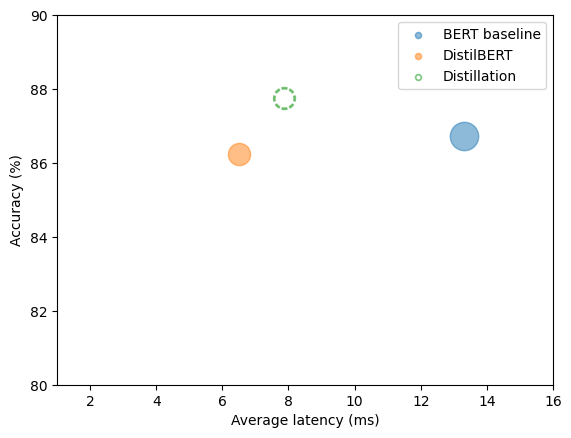

In [75]:
plot_metrics(perf_metrics, optim_type)

## 양자화로 모델 속도 높이기

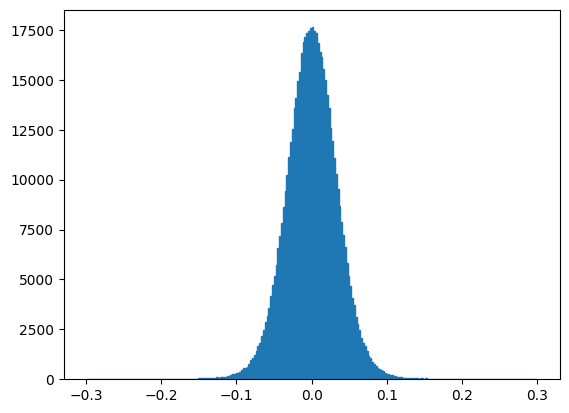

In [76]:
import matplotlib.pyplot as plt

state_dict = pipe.model.state_dict()
weights = state_dict["distilbert.transformer.layer.0.attention.out_lin.weight"]
plt.hist(weights.flatten().numpy(), bins=250, range=(-0.3,0.3), edgecolor="C0")
plt.show()

In [77]:
zero_point = 0
scale = (weights.max() - weights.min()) / (127 - (-128))

In [78]:
(weights / scale + zero_point).clamp(-128, 127).round().char()

tensor([[ -5,  -8,   0,  ...,  -6,  -4,   8],
        [  9,   3,   1,  ...,  -4,   7,   0],
        [ -9,  -6,   5,  ...,   0,   5,  -4],
        ...,
        [  6,   0,  12,  ...,   0,   6,  -1],
        [  0,  -2, -12,  ...,  12,  -7, -13],
        [-13,  -1, -10,  ...,   8,   2,  -2]], dtype=torch.int8)

In [79]:
from torch import quantize_per_tensor

dtype = torch.qint8
quantized_weights = quantize_per_tensor(weights, scale, zero_point, dtype)
quantized_weights.int_repr()

tensor([[ -5,  -8,   0,  ...,  -6,  -4,   8],
        [  9,   3,   1,  ...,  -4,   7,   0],
        [ -9,  -6,   5,  ...,   0,   5,  -4],
        ...,
        [  6,   0,  12,  ...,   0,   6,  -1],
        [  0,  -2, -12,  ...,  12,  -7, -13],
        [-13,  -1, -10,  ...,   8,   2,  -2]], dtype=torch.int8)

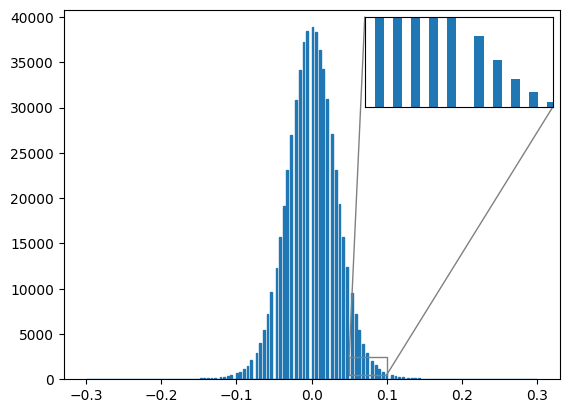

In [82]:
# 트랜스포머 가중치에서 양자화 효과
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes,mark_inset

# 히스토그램 그리기
fig, ax = plt.subplots()
ax.hist(quantized_weights.dequantize().flatten().numpy(),
         bins=250, range=(-0.3,0.3), edgecolor="C0");
# 확대 그림 만들기
axins = zoomed_inset_axes(ax, 5, loc='upper right')
axins.hist(quantized_weights.dequantize().flatten().numpy(),
         bins=250, range=(-0.3,0.3));
x1, x2, y1, y2 = 0.05, 0.1, 500, 2500
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.axes.xaxis.set_visible(False)
axins.axes.yaxis.set_visible(False)
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")
plt.show()

In [83]:
%%timeit
weights @ weights

1.34 ms ± 1.78 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [84]:
from torch.nn.quantized import QFunctional

q_fn = QFunctional()

In [85]:
%%timeit
q_fn.mul(quantized_weights, quantized_weights)

96.2 µs ± 22.1 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [86]:
import sys

sys.getsizeof(weights.untyped_storage()) / sys.getsizeof(quantized_weights.untyped_storage())

3.999633833760527

In [87]:
from torch.quantization import quantize_dynamic

# `haesun`를 자신의 허브 사용자 이름으로 바꾸세요.
model_ckpt = "restful3/distilbert-base-uncased-distilled-clinc"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt).to("cpu"))

model_quantized = quantize_dynamic(model, {nn.Linear}, dtype=torch.qint8)

### 양자화된 모델의 벤치마크 수행하기

In [88]:
pipe = pipeline("text-classification", model=model_quantized,
                tokenizer=tokenizer)
optim_type = "Distillation + quantization"
pb = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

모델 크기 (MB) - 132.39
평균 레이턴시 (ms) - 4.37 +\- 0.51
테스트 세트 정확도 - 0.884


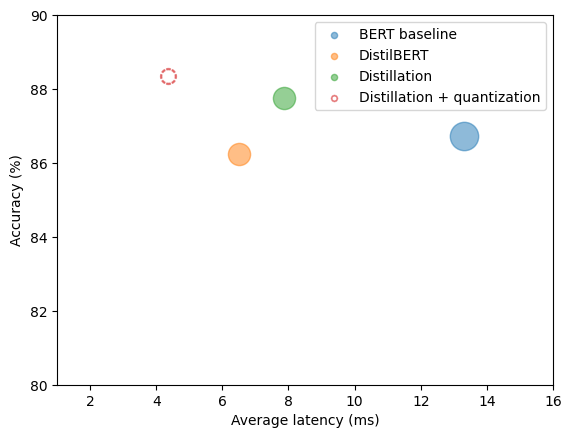

In [89]:
plot_metrics(perf_metrics, optim_type)

## ONNX와 ONNX 런타임으로 추론 최적화하기

In [1]:
import os
from psutil import cpu_count

os.environ["OMP_NUM_THREADS"] = f"{cpu_count()}"
os.environ["OMP_WAIT_POLICY"] = "ACTIVE"

In [3]:
from transformers.convert_graph_to_onnx import convert
import torch
from pathlib import Path
from transformers import AutoTokenizer


# `haesun`를 자신의 허브 사용자 이름으로 바꾸세요.
model_ckpt = "restful3/distilbert-base-uncased-distilled-clinc"
onnx_model_path = Path("onnx/model.onnx")
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

convert(framework="pt", model=model_ckpt, tokenizer=tokenizer,
        output=onnx_model_path, opset=12, pipeline_name="text-classification")

/home/restful3/anaconda3/envs/trading/lib/python3.9/site-packages/transformers/convert_graph_to_onnx.py:379: FutureWarning: The `transformers.convert_graph_to_onnx` package is deprecated and will be removed in version 5 of Transformers
  warnings.warn(


ONNX opset version set to: 12
Loading pipeline (model: restful3/distilbert-base-uncased-distilled-clinc, tokenizer: DistilBertTokenizerFast(name_or_path='restful3/distilbert-base-uncased-distilled-clinc', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True))


WARNING[XFORMERS]: xFormers can't load C++/CUDA extensions. xFormers was built for:
    PyTorch 2.2.1+cu121 with CUDA 1201 (you have 2.2.1)
    Python  3.9.18 (you have 3.9.18)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
  Set XFORMERS_MORE_DETAILS=1 for more details


Using framework PyTorch: 2.2.1
Found input input_ids with shape: {0: 'batch', 1: 'sequence'}
Found input attention_mask with shape: {0: 'batch', 1: 'sequence'}
Found output output_0 with shape: {0: 'batch'}
Ensuring inputs are in correct order
head_mask is not present in the generated input list.
Generated inputs order: ['input_ids', 'attention_mask']


/home/restful3/anaconda3/envs/trading/lib/python3.9/site-packages/transformers/models/distilbert/modeling_distilbert.py:223: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  mask, torch.tensor(torch.finfo(scores.dtype).min)


In [6]:
from onnxruntime import (GraphOptimizationLevel, InferenceSession,
                         SessionOptions)

def create_model_for_provider(model_path, provider="CPUExecutionProvider"):
    options = SessionOptions()
    options.intra_op_num_threads = 1
    options.graph_optimization_level = GraphOptimizationLevel.ORT_ENABLE_ALL
    session = InferenceSession(str(model_path), options, providers=[provider])
    session.disable_fallback()
    return session

In [7]:
onnx_model = create_model_for_provider(onnx_model_path)

In [30]:
inputs = clinc_enc["test"][:1]
del inputs["labels"]
logits_onnx = onnx_model.run(None, inputs)[0]
logits_onnx.shape

(1, 151)

In [31]:
np.argmax(logits_onnx)

61

In [32]:
clinc_enc["test"][0]["labels"]

61

In [33]:
from scipy.special import softmax

class OnnxPipeline:
    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer

    def __call__(self, query):
        model_inputs = self.tokenizer(query, return_tensors="pt")
        inputs_onnx = {k: v.cpu().detach().numpy()
                       for k, v in model_inputs.items()}
        logits = self.model.run(None, inputs_onnx)[0][0, :]
        probs = softmax(logits)
        pred_idx = np.argmax(probs).item()
        return [{"label": intents.int2str(pred_idx), "score": probs[pred_idx]}]

In [34]:
pipe = OnnxPipeline(onnx_model, tokenizer)
pipe(query)

[{'label': 'car_rental', 'score': 0.8501304}]

In [35]:
class OnnxPerformanceBenchmark(PerformanceBenchmark):
    def __init__(self, *args, model_path, **kwargs):
        super().__init__(*args, **kwargs)
        self.model_path = model_path

    def compute_size(self):
        size_mb = Path(self.model_path).stat().st_size / (1024 * 1024)
        print(f"모델 크기 (MB) - {size_mb:.2f}")
        return {"size_mb": size_mb}

In [36]:
optim_type = "Distillation + ORT"
pb = OnnxPerformanceBenchmark(pipe, clinc["test"], optim_type,
                              model_path="onnx/model.onnx")
perf_metrics.update(pb.run_benchmark())

모델 크기 (MB) - 255.98
평균 레이턴시 (ms) - 26.05 +\- 0.05
테스트 세트 정확도 - 0.877
